# Bayesian Posterior Analysis: Mean


## Conjugate Priors

Suppose that your data was drawn from a Normal distribution with an unknown mean $\mu$ and an unknown variance $\sigma^2$. In this case, the conjugate prior is the [Normal-inverse-gamma (NIG) distribution](https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution). That is, our prior is

$$(\mu, \sigma^2) \sim NIG(\mu_0, \nu, \alpha, \beta)$$

We interpret $\mu$ as having been drawn from a Normal distribution with mean $\mu_0$ and variance $\sigma^2$, and $\nu$ observations were used to estimate it. $\sigma^2$ was drawn from an [inverse-gamma distribution](https://en.wikipedia.org/wiki/Inverse-gamma_distribution), and was estimated using $2 \alpha$ observations that had mean $\mu_0$ and sum of squared deviations $2 \beta$. In other words, $\mu_0$ is your best guess for $\mu$ prior to collecting data, $\frac{\beta}{\alpha}$ is your best guess for $\sigma^2$ prior to collecting data, and $\nu$ and $\alpha$ quantify how confident you are in your prior beliefs (with larger $\nu$ and $\alpha$ indicating more confidence).

Assuming that $\mu$ and $\sigma^2$ are independent of one another, if we have a dataset $x_1, ..., x_n$, the posterior distribution of $(\mu, \sigma^2)$ is

$$NIG\left(\frac{\nu \mu_0 + n \bar{x}}{\nu + n}, \nu + n, \alpha + \frac{n}{2}, \beta + \frac{1}{2}\sum_{i = 1}^n (x_i - \bar{x})^2 + \frac{\nu n}{\nu + n} \frac{(\bar{x} - \mu_0)^2}{2} \right)$$

The marginal distribution is often of greatest interest to us, though. In this video I'm primarily interested in the mean, and thus the marginal distribution of $\mu$. The prior marginal distribution of $\sqrt{\frac{\alpha \nu}{\beta}}(\mu - \mu_0)$ is $t(2\alpha)$, and the posterior marginal distribution of

$$\sqrt{\frac{(n + \nu)\left(\alpha + \frac{n}{2}\right)}{\beta + \frac{1}{2}\sum_{i = 1}^n (x_i - \bar{x})^2 + \frac{\nu n}{\nu + n} \frac{(\bar{x} - \mu_0)^2}{2}}}(\mu - \nu \mu_0 + n \bar{x}{\nu + n})$$

is $t(2\alpha + n)$.

This is all a lot to take in, so I have written helper functions that:

1. Compute the **probability density function (PDF)** of $(\mu, \sigma^2)$. (Useful for plotting.)
2. Compute the parameters of the posterior distribution of $(\mu, \sigma^2)$.
3. Compute the PDF and CDF of the marginal distribution of $\mu$ (for either the prior or posterior distribution).
4. Computes the inverse CDF of the marginal distribution of $\mu$ (for either the prior or posterior distribution).
5. Simulate a draw from the marginal distribution of $\mu$ (for either the prior or posterior distribution).

In [12]:
import numpy as np
from scipy.special import gamma
from scipy.stats import t
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def dnig(x, s, mu, nu, alpha, beta):
    """Computes the PDF of the NIG(mu, nu, alpha, beta) distribution
    
    args:
        x: float; The x coordinate of the PDF
        s: float; The s coordinate of the PDF (corresponds to sigma^2)
        mu: float; The mu parameter of NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of NIG(mu, nu, alpha, beta)
    
    return:
        float; The value of the PDF
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    return np.sqrt(nu / (np.abs(s) * 2 * np.pi)) * beta ** alpha / gamma(alpha) *\
           s**(-(alpha + 1)) * np.exp(-(2*beta + nu * (x - mu)**2)/(2*s)) * np.maximum(s, 0)

In [14]:
def get_posterior_nig(x, mu, nu, alpha, beta):
    """Computes the parameters of the posterior NIG distribution
    
    args:
        x: array-like; The data set
        mu: float; prior parameter mu
        nu: float; prior parameter nu
        alpha: foat; prior parameter alpha
        beta: float; prior parameter beta
    
    return:
        tuple: Of the form (mu, nu, alpha, beta)
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    xbar = x.mean()
    n = len(x)
    
    p_mu = (nu * mu + n * xbar)/(nu + n)
    p_nu = nu + n
    p_alpha = alpha + n/2
    p_beta = beta + ((x - xbar)**2).sum()/2 + n * nu / (n + nu) * (xbar - mu)**2/2
    
    return (p_mu, p_nu, p_alpha, p_beta)

In [15]:
def dnig_mu_marg(x, mu, nu, alpha, beta):
    """Computes the PDF of the marginal distribution of mu from a NIG distribution
    
    args:
        x: float; The value at which the PDF is being evaluated
        mu: float; The mu parameter of NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of NIG(mu, nu, alpha, beta)
        
    return:
        float; The value of the PDF at x
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    y = np.sqrt(alpha * nu / beta) * (x - mu)
    
    return t.pdf(y, df = 2*alpha) * np.sqrt(alpha * nu / beta)

In [16]:
def pnig_mu_marg(x, mu, nu, alpha, beta):
    """Computes the CDF of the marginal distribution of mu from a NIG distribution
    
    args:
        x: float; The value at which the CDF is being evaluated
        mu: float; The mu parameter of NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of NIG(mu, nu, alpha, beta)
        
    return:
        float; The value of the CDF at x
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    y = np.sqrt(alpha * nu / beta) * (x - mu)
    
    return t.cdf(y, df = 2*alpha)

In [17]:
def qnig_mu_marg(p, mu, nu, alpha, beta):
    """Computes the inverse CDF (quantile) of the marginal distribution of mu from a NIG distribution
    
    args:
        p: float; The value at which the inverse CDF is being evaluated
        mu: float; The mu parameter of NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of NIG(mu, nu, alpha, beta)
        
    return:
        float; The value of the CDF at x
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    if p < 0 or p > 1:
        raise ValueError("p must be a value that could be interpreted as a probability")
    
    y = t.ppf(p, 2*alpha)
    m = np.sqrt(beta / (nu * alpha)) * y + mu
    
    return m

In [18]:
def rnig_mu_marg(mu, nu, alpha, beta, n=1):
    """Draw random instances from the marginal distribution of mu from a NIG distribution
    
    args:
        n: int; The number of random numbers to generate
        mu: float; The mu parameter of NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of NIG(mu, nu, alpha, beta)
        
    return:
        np.array; Random instances of mu
    """
    
    if nu < 0 or alpha < 0 or beta < 0:
        raise ValueError("Cannot have negative nu, alpha, beta")
    
    if type(n) is not int:
        raise TypeError("n must be int")
    elif n <= 0:
        raise ValueError("n must be positive")
    
    y = t.rvs(df=2*alpha, size=n)
    m = np.sqrt(beta / (nu * alpha)) * y + mu
    
    return m

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


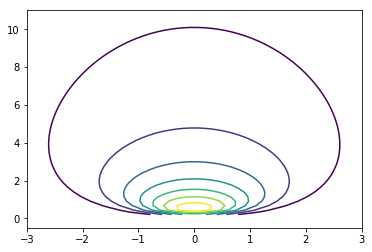

In [19]:
# Demonstrating dnig
x = np.linspace(-3, 3)
y = np.linspace(-0.5, 11)
X, Y = np.meshgrid(x, y)

plt.contour(X, Y, dnig(X, Y, 0, 1, 1/2, 1/2))
plt.show()

## Credible Interval for the Mean

You are employed by a company that fabricates chips and other electronic components. The company wants you to investigates the resistors it uses in producing its components. In particular, while the resistors used by the company are labeled with a particular resistance, the company wants to ensure the manufacturer of the resistors produces quality products. Your task is to verify that the labeled resistance agrees with the observed resistance, after subjecting the resistors to testing.

You test the resistance (in kΩkΩ) of some resistors labeled 1kΩ1kΩ and obtain the following dataset (stored in a NumPy array).

In [20]:
res = np.array([ 0.984,  0.988,  0.984,  0.987,  0.976,  0.997,  0.993,  0.985,
                 1.002,  0.987,  1.005,  0.993,  0.987,  0.992,  0.976,  0.998,
                 1.011,  0.971,  0.981,  1.008,  0.963,  0.992,  0.995,  0.99 ,
                 0.996,  0.99 ,  0.985,  0.997,  0.983,  0.981,  0.988,  0.991,
                 0.971,  0.982,  0.979,  1.008,  1.006,  1.006,  1.001,  0.999,
                 0.98 ,  0.996,  0.979,  1.009,  0.99 ,  0.996,  1.001,  0.981,
                 0.99 ,  0.987,  0.97 ,  0.992,  0.982,  0.983,  0.974,  0.999,
                 0.987,  1.002,  0.971,  0.982,  0.989,  0.985,  1.014,  0.991,
                 0.984,  0.992,  1.003,  0.985,  0.987,  0.985,  1.   ,  0.978,
                 0.99 ,  0.99 ,  0.985,  0.983,  0.981,  0.993,  0.993,  0.973,
                 1.   ,  0.982,  0.987,  0.988,  0.982,  0.978,  0.989,  1.   ,
                 0.983,  1.008,  0.997,  0.974,  0.988,  1.002,  0.988,  0.994,
                 0.991,  1.   ,  0.976,  0.987,  0.991,  1.010,  0.999,  1.002])

For the prior, you use the $NIG(1, 1, 1/2, 0.0005)$ distribution. The parameters of the posterior distribution are computed below.

In [21]:
post = get_posterior_nig(res, 1, 1, 1/2, 0.0005)
post

(0.98986666666666678, 105, 52.5, 0.0060270666666666656)

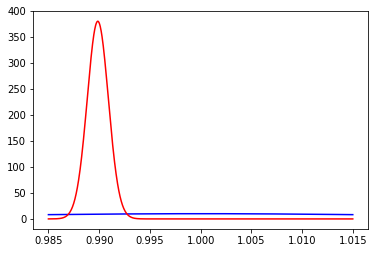

In [22]:
# Visualizing the prior and posterior
x1 = np.linspace(0.985, 1.015, 1000)
plt.plot(x1, dnig_mu_marg(x1, 1, 1, 1/2, 0.0005), 'b-')    # Prior
plt.plot(x1, dnig_mu_marg(x1, *post), 'r-')    # Posterior
plt.show()

The function below computes $100\times C$% credible intervals for the mean $\mu$.

In [23]:
def mean_normal_nig_credible_interval(x, mu, nu, alpha, beta, C=0.95):
    """Computes a 100C% credible interval for the mean mu
    
    args:
        x: array-like; The data
        mu: float; The mu parameter of prior NIG(mu, nu, alpha, beta)
        nu: float; The nu parameter of prior NIG(mu, nu, alpha, beta)
        alpha: float; The alpha parameter of prior NIG(mu, nu, alpha, beta)
        beta: float; The beta parameter of prior NIG(mu, nu, alpha, beta)
        C: float; the credibility (chance of containing mu) of the interval
    
    return:
        tuple; first number is the lower bound, second the upper bound, of the credible interval
    """
    
    if C < 0 or C > 1:
        raise ValueError("C must be interpretable as a probability")
    
    p_mu, p_nu, p_alpha, p_beta = get_posterior_nig(x, mu, nu, alpha, beta)
    alpha = (1 - C)/2
    
    lower = qnig_mu_marg(alpha, p_mu, p_nu, p_alpha, p_beta)
    upper = qnig_mu_marg(1 - alpha, p_mu, p_nu, p_alpha, p_beta)
    
    return (lower, upper)

In [24]:
mean_normal_nig_credible_interval(res, 1, 1, 1/2, 0.0005)    # Compute the credible interval

(0.98779337237452103, 0.99193996095881254)

Given this credible interval it's likely that the resistors likely don't have a mean resistance of $1\text{k}\Omega$.

## Bayesian Hypothesis Testing

You suspect that the resistors being sent to your company have a mean resistance that is less than labeled. Having obtained the posterior distribution you can compute the probability that $\mu < 1\text{k}\Omega$.

In [25]:
p_mu, p_nu, p_alpha, p_beta = get_posterior_nig(res, 1, 1, 1/2, 0.0005)

pnig_mu_marg(1, p_mu, p_nu, p_alpha, p_beta)    # Computes probability that mu < 1 from posterior distribution

0.99999999999999978

This probability is very high! It's all but certain that the resistors are not properly callibrated. 

## Two-Sample Testing
In light of your study the manager of your division has decided to stop outsourcing resistor production. The company wants to start manufacturing its own resistors, and has started experimenting with different processes before engaging in full-scale production.

Right now there are two manufacturing processes known as process A and process B, and you are tasked with determining whether the mean resistance of supposedly-$1\text{k}\Omega$ resistors produced by process A is less than the resistance of resistors produced by process B. That is, you want to know the probability that $\mu_A < \mu_B$.

The distribution of $(\mu_A, \mu_B)$ is difficult to compute, but if you assume that $\mu_A$ and $\mu_B$ are independent of each other, you could do the following:

1. Collect data from both processes and compute the posterior distributions for both $\mu_A$ and $\mu_B$.
2. Simulate random draws of $\mu_A$ and $\mu_B$ from the posterior distributions.
3. Compute how often $\mu_A < \mu_B$ to estimate the probability that $\mu_A < \mu_B$.

You collect data for both processes, which is listed below:

In [26]:
res_A = np.array([ 1.002,  1.001,  1.   ,  0.999,  0.998,  1.   ,  1.001,  0.999,
                   1.002,  0.998,  1.   ,  0.998,  1.001,  1.001,  1.002,  0.997,
                   1.001,  1.   ,  1.001,  0.999,  0.998,  0.998,  1.002,  1.002,
                   0.996,  0.998,  0.997,  1.001,  1.002,  0.997,  1.   ,  1.   ,
                   0.998,  0.997])

res_B = np.array([ 0.995,  1.022,  0.993,  1.014,  0.998,  0.99 ,  0.998,  0.998,
                   0.99 ,  1.003,  1.016,  0.992,  1.   ,  1.002,  1.003,  1.005,
                   0.979,  1.012,  0.978,  1.01 ,  1.001,  1.026,  1.011,  1.   ,
                   0.98 ,  0.993,  1.016,  0.991,  0.986,  0.987,  1.012,  0.996,
                   1.013,  1.001,  0.984,  1.011,  1.01 ,  1.   ,  1.001])

You now compute the posterior distributions for $\mu_A$ and $\mu_B$ from the two processes.

In [27]:
postA = get_posterior_nig(res_A, 1, 1, 1/2, 0.0005)    # Posterior for process A
postA

(0.99959999999999993, 35, 17.5, 0.00055419999999999905)

In [28]:
postB = get_posterior_nig(res_B, 1, 1, 1/2, 0.0005)    # Posterior for process B
postB

(1.0004249999999999, 40, 20.0, 0.0031258874999999997)

In [29]:
N = 1000    # Number of simulations
simA = rnig_mu_marg(*postA, n=N)    # Drawing random mu_A from posterior
simB = rnig_mu_marg(*postB, n=N)    # Drawing random mu_B from posterior

In [30]:
simA[0:10]

array([ 1.00015755,  1.00161933,  0.99947781,  0.99831549,  1.00045561,
        1.00079888,  0.99945825,  1.00089967,  0.99857731,  1.00105659])

In [31]:
simB[0:10]

array([ 0.99990816,  1.0001684 ,  0.99840418,  1.00165434,  1.00228087,
        1.0004694 ,  1.00644592,  0.99794126,  1.00166433,  0.99662504])

In [32]:
sim = simA < simB    # mu_A < mu_B
sim[0:10]

array([False, False, False,  True,  True, False,  True, False,  True, False], dtype=bool)

In [33]:
sim.sum()    # The frequency this occurs

661

In [34]:
sim.mean()    # The estimated probability that mu_A < mu_B

0.66100000000000003

The estimated probability that $\mu_A < \mu_B$ is higher than 50%, which is mildly convincing but not by much.